In [0]:
!cp ./drive/My\ Drive/Colab\ Notebooks/class-MachineLearning/11/movie_review.zip ./
!unzip ./movie_review.zip
!rm -rf ./movie_review/Icon ./movie_review/pos/Icon ./movie_review/neg/Icon

## 1. Load data from files

In [0]:
from sklearn.datasets import load_files

DATA_PATH = './movie_review'

data = load_files(DATA_PATH)
X_raw, Y_raw = data.data, data.target

## 2. Data preprocessing

### 2-1. Text preprocessing

In [193]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag, word_tokenize

nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

docs = []
stemmer = WordNetLemmatizer()

# text preprocssing
for doc_raw in X_raw:
  # byte to string
  doc = doc_raw.decode('utf-8')
  
  # remove all the special characters
  doc = re.sub(r'\W', ' ', doc)

  # remove all single characters
  doc = re.sub(r'\s+[a-zA-Z]\s+', ' ', doc)
  doc = re.sub(r'\^[a-zA-Z]\s+', ' ', doc)

  # substitute multiple spaces with single space
  doc = re.sub(r'\s+', ' ', doc, flags=re.I)

  # convert to lowercase
  doc = doc.lower()

  # lemmatization
  word_list = doc.split()
  lemma_word_list = []
  for word, tag in pos_tag(word_list):
    main_tag = tag[0].lower()
    lemma_word = ''

    if main_tag in ['a', 'r', 'n', 'v']:
      lemma_word = stemmer.lemmatize(word, main_tag)
    else:
      lemma_word = word

    lemma_word_list.append(lemma_word)

  doc = ' '.join(lemma_word_list)
  docs.append(doc)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


### 2-2. Documents to vectors

In [0]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import train_test_split
from sklearn.decomposition import TruncatedSVD
import numpy as np

# documents to tfidf vector
vectorizer = CountVectorizer(max_features=4000, min_df=0.01, max_df=0.8, stop_words=stopwords.words('english'))
X_data = vectorizer.fit_transform(docs).toarray()
tfidf_transformer = TfidfTransformer(sublinear_tf=True)
X_data = tfidf_transformer.fit_transform(X_data).toarray()

# singular value decompostion
svd_model = TruncatedSVD(n_components=200)
X_data = svd_model.fit_transform(X_data)

Y_data = Y_raw

X_train, X_test, Y_train, Y_test = train_test_split(X_data, Y_data, test_size=0.3, shuffle=False)

### 2-3. Move data to GPU

In [0]:
import torch

# device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

X_train = torch.from_numpy(X_train).to(device)
Y_train = torch.from_numpy(Y_train).to(device).reshape(-1, 1)

X_test = torch.from_numpy(X_test).to(device)
Y_test = torch.from_numpy(Y_test).to(device).reshape(-1, 1)

## 3. Define model and functions for learning neural network

In [0]:
import math

def initialize_weights(fan_in, fan_out):
  # xavier initialization
  return math.sqrt(1 / fan_in) * torch.randn(fan_out, fan_in)

def activation(z):
  return 1 / (1 + torch.exp(-z))

def objective(Y_pred, Y, lam=0, params=None):
  epsilon = 1e-8
  data_fidelity_term = (-1 / Y.shape[0]) * torch.sum(
      Y * torch.log(Y_pred + epsilon) + (1 - Y) * torch.log(1 - Y_pred + epsilon)
  )

  decay_term = 0
  if lam is not 0:
    num_of_params = 0   # n
    sum_of_params = 0   # sigma theta^2
    for param in params.values():
      num_of_params += param.shape[0] * param.shape[1]
      sum_of_params += torch.sum(param ** 2)

    decay_term = (lam / (2 * num_of_params)) * sum_of_params

  return data_fidelity_term + decay_term

def accuracy(Y_pred, Y):
  answer = (Y_pred >= 0.5).float()
  return torch.mean((answer == Y).float())


class FNN:
  def __init__(self, layer_size_list):
    self.num_of_layer = len(layer_size_list) - 1
    self.params = dict()

    # initialize params w and b (w is weights and b is biases)
    for i in range(len(layer_size_list) - 1):
      fan_in = layer_size_list[i]
      fan_out = layer_size_list[i + 1]

      self.params['w' + str(i + 1)] = initialize_weights(fan_in, fan_out).double().to(device)
      self.params['b' + str(i + 1)] = torch.zeros(1, fan_out).double().to(device)

  def forward(self, X):
    forward_results = dict()
    forward_results['a0'] = X

    # z is fully connected layer's result and
    # a is activation function's result
    for i in range(self.num_of_layer):
      prev_a = forward_results['a' + str(i)]
      curr_w = self.params['w' + str(i + 1)]
      curr_b = self.params['b' + str(i + 1)]

      forward_results['z' + str(i + 1)] = torch.matmul(prev_a, curr_w.T) + curr_b
      forward_results['a' + str(i + 1)] = activation(forward_results['z' + str(i + 1)])

    forward_results['Y_pred'] = forward_results['a' + str(self.num_of_layer)]

    return forward_results

  def backward(self, X, Y, forward_results, lam=0):
    grads = dict()

    dz_last = (forward_results['a' + str(self.num_of_layer)] - Y) / X.shape[0]

    # reverse order because of `back`ward propagation
    for i in range(self.num_of_layer)[::-1]:
      curr_a = forward_results['a' + str(i + 1)]
      next_a = forward_results['a' + str(i)]

      if i == (self.num_of_layer - 1):  # if last layer
        grads['z' + str(i + 1)] = (curr_a - Y) / X.shape[0]
      else:
        prev_dz = grads['z' + str(i + 2)]
        prev_w = self.params['w' + str(i + 2)]

        grads['a' + str(i + 1)] = torch.matmul(prev_dz, prev_w)
        grads['z' + str(i + 1)] = curr_a * (1 - curr_a) * grads['a' + str(i + 1)]

      grads['w' + str(i + 1)] = torch.matmul(grads['z' + str(i + 1)].T, next_a)
      grads['b' + str(i + 1)] = torch.sum(grads['z' + str(i + 1)], axis=0).reshape(1, -1)

    # remain only the gradients of w and b
    for key in list(grads.keys()):
      if key.startswith('z') or key.startswith('a'):
        del grads[key]

    # apply gradients of decay term
    if lam is not 0:
      n = 0
      for param in self.params.values():
        n += param.shape[0] * param.shape[1]

      for key in grads.keys():
        grads[key] += (lam / n) * self.params[key]

    return grads

## 4. Learning with the gradient descent algorithm


In [538]:
lr = 0.5
lam = 0
epoch_count = 5000
fnn = FNN((200, 400, 1))

history = {
    'train_loss': [],
    'test_loss': [],
    'train_acc': [],
    'test_acc': []
}

for epoch in range(epoch_count):
  # learning rate annealing
  # if epoch != 0 and epoch % 1000 == 0:
  #   lr = max(lr - 0.1, 0.1)

  # forward propagation using train data
  train_forward_results = fnn.forward(X_train)

  # calculate training loss and accuracy
  Y_train_pred = train_forward_results['Y_pred']
  train_loss = objective(Y_train_pred, Y_train, lam, fnn.params)
  train_acc = accuracy(Y_train_pred, Y_train)

  # forward propagation using test data
  test_forward_results = fnn.forward(X_test)

  # calculate testing loss and accuracy
  Y_test_pred = test_forward_results['Y_pred']
  test_loss = objective(Y_test_pred, Y_test, lam, fnn.params)
  test_acc = accuracy(Y_test_pred, Y_test)

  # log history
  history['train_loss'].append(train_loss.item())
  history['test_loss'].append(test_loss.item())
  history['train_acc'].append(train_acc.item())
  history['test_acc'].append(test_acc.item())

  # gradient descent
  grads = fnn.backward(X_train, Y_train, train_forward_results, lam)
  for key in fnn.params.keys():
    fnn.params[key] -= lr * grads[key]

# convert each history list to numpy array
for key in history.keys():
  history[key] = np.array(history[key])

print(f'train acc: {history["train_acc"][-1]}')
print(f'test acc: {history["test_acc"][-1]}')

train acc: 0.9307142496109009
test acc: 0.8666666746139526


In [539]:
np.max(history["test_acc"])

0.871666669845581

## 5. Results


### 5-1. Plot the loss curve

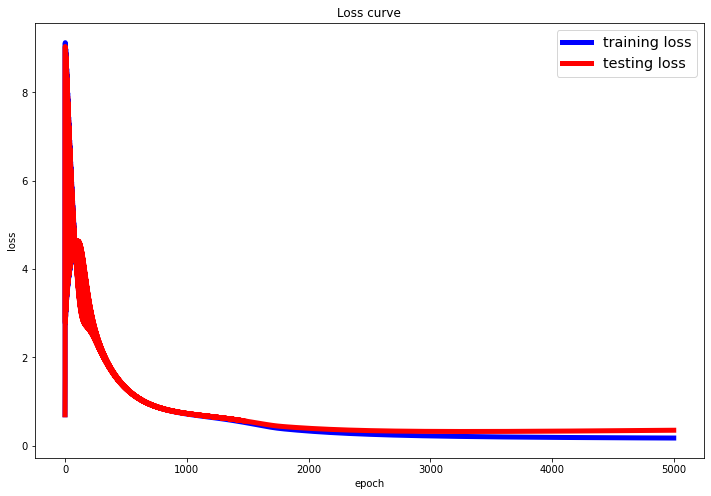

In [540]:
import matplotlib.pyplot as plt

epoch_tick = np.arange(epoch_count)

plt.figure(figsize=(12, 8))
plt.title('Loss curve')
plt.plot(epoch_tick, history['train_loss'], 'b-', linewidth=5)
plt.plot(epoch_tick, history['test_loss'], 'r-', linewidth=5)
plt.legend(['training loss', 'testing loss'], fontsize='x-large', loc='upper right')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

### 5-2. Plot the accuracy curve

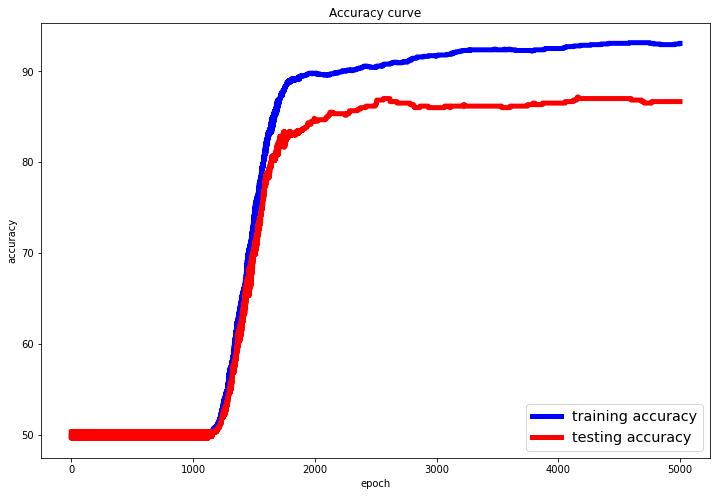

In [541]:
plt.figure(figsize=(12, 8))
plt.title('Accuracy curve')
plt.plot(epoch_tick, history['train_acc'] * 100, 'b-', linewidth=5)
plt.plot(epoch_tick, history['test_acc'] * 100, 'r-', linewidth=5)
plt.legend(['training accuracy', 'testing accuracy'], fontsize='x-large', loc='lower right')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()